In [1018]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.modeling import models, fitting
from scipy.optimize import curve_fit, least_squares, leastsq
import glob
import os
from numpy import exp 
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit, least_squares, leastsq

plt.style.use('seaborn-v0_8-white')
plt.rcParams['font.family'] = "Serif"
from IPython import display

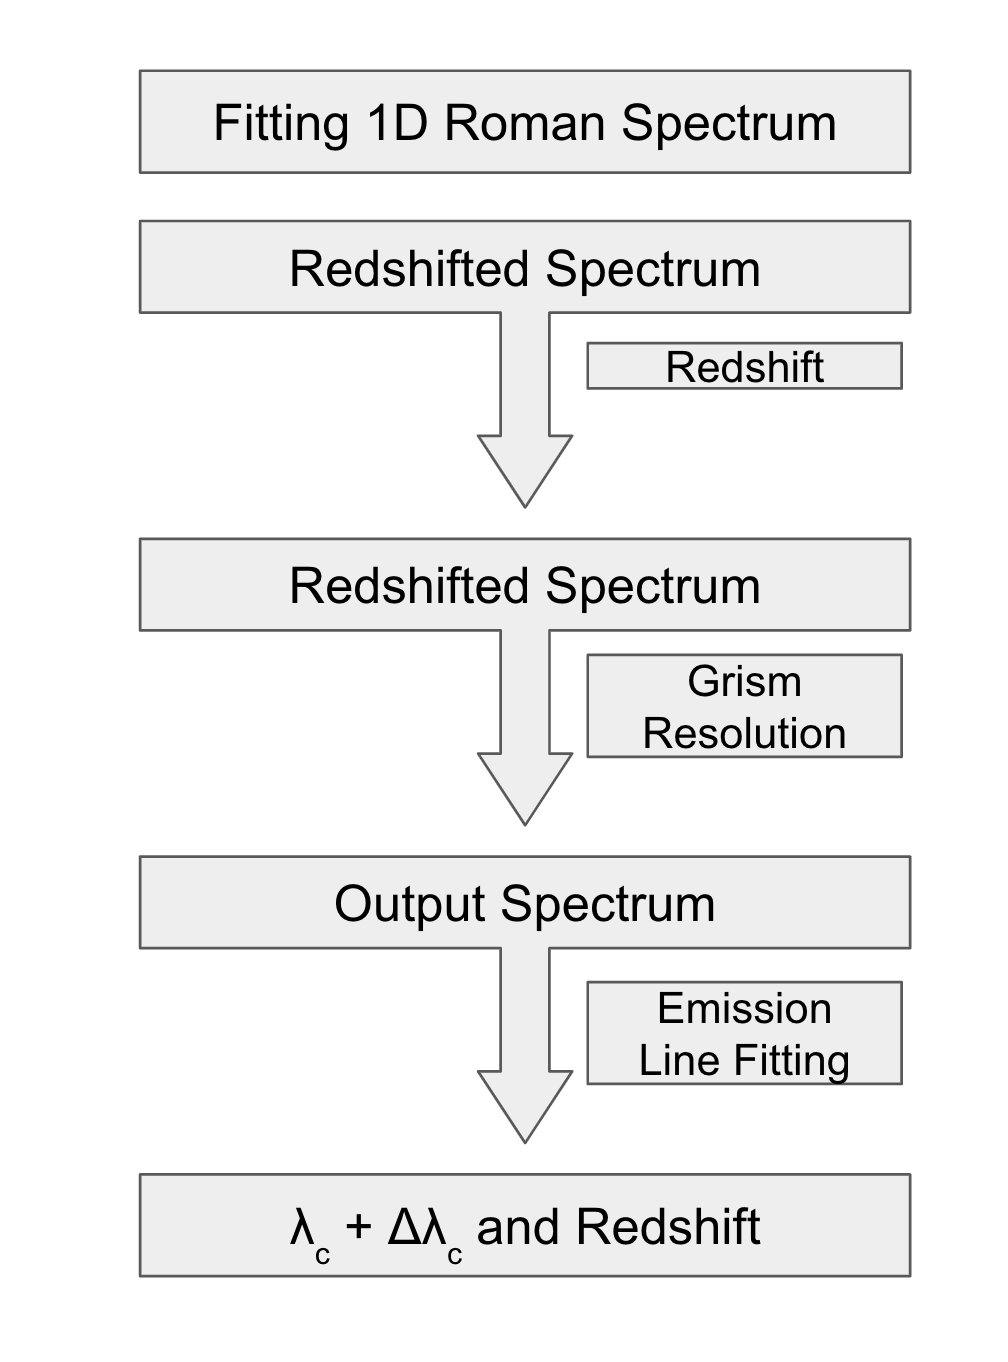

In [1110]:
display.Image("/Users/slkumar/Desktop/notebookflowchart.png", width = 400, height = 300)

# Goals: 
## - How to transform template spectra into Roman Grism spectra
## - Be able to estimate redshift and line fluxes using the methods here

# **Part 1: Transforming Template Spectra into Grism Resolution**

The first part of this notebook aims to inform you about what spectra look like that are not within Roman's Grism resolution. 

# Fitting an Emission Line

### Step 1: Load and read a spectra file (Make sure to change the username here!)

In [1254]:
data=np.loadtxt('/Users/slkumar/RomanSpectraDataChallenge/spectra/galaxy/emission_line_galaxy1_v3.txt') 

The `np.loadtxt()` function reads the file containing the spectrum data.

The file contains columns for flux, log_wavelength, and inverse variance.

The data is stored as a 2D array where each row corresponds to a single data point.


In [1257]:
flux=data.T[1]

data.T transposes the array, swapping rows and columns.

The first column (index 0) corresponds to the flux values, which measure the brightness at each wavelength.

This is extracted and stored in the variable flux.

In [1260]:
wav = data.T[0]

Extract logarithmic wavelength:

The second column (index 1) contains the logarithm (base 10) of the wavelength values.

These logarithmic values are stored in log_lam.

## Step 2 - Look at the spectrum to identify emission lines

Here is what this spectrum looks like in its restframe

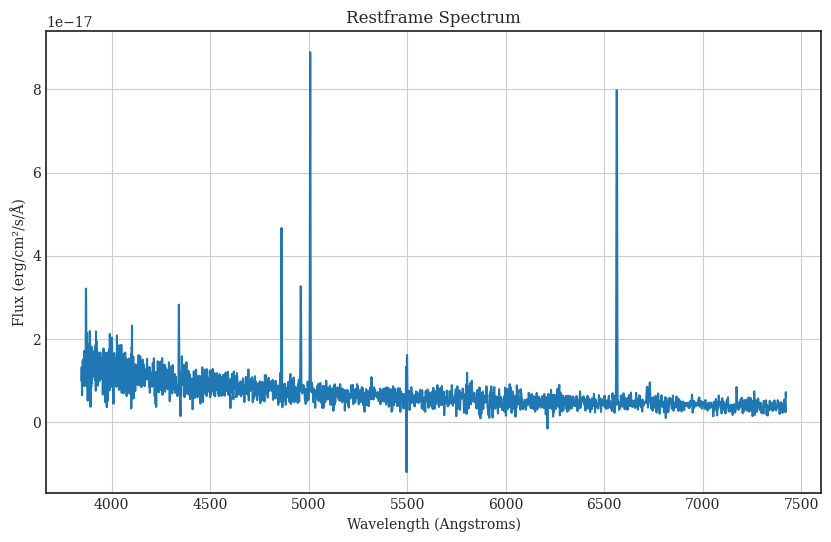

In [1025]:
'''This spectrum has been redshfited to 1.6 which we can then put into its restframe by dividing by (1+1.6) for 
the wavelength and multiplying by 1.6 for the flux'''

rest_flux = flux * (1 + 1.6)
rest_wav = wav/(1+1.6)

plt.figure(figsize = (10,6))
plt.plot(rest_wav, rest_flux)
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/cm²/s/Å)')
plt.title("Restframe Spectrum")
plt.grid()
plt.show()

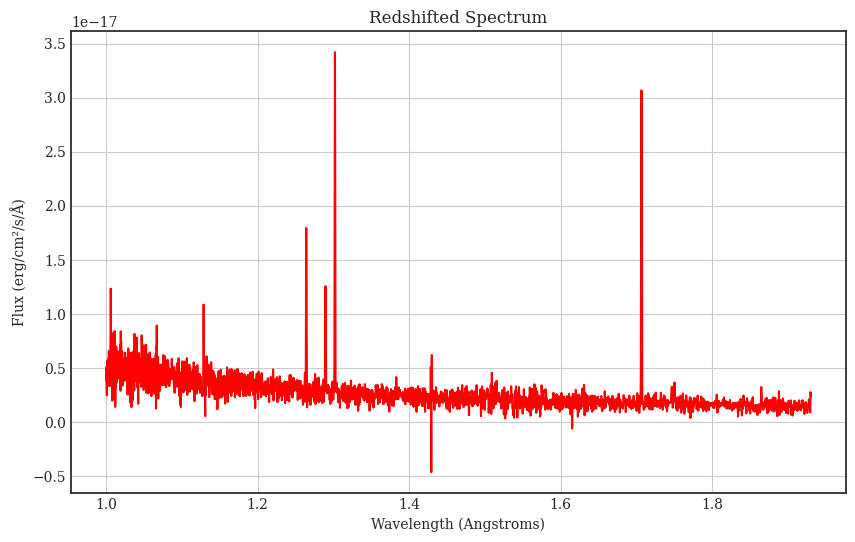

In [1027]:
plt.figure(figsize=(10, 6))
plt.plot(wav/1e4, flux, color='red')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux (erg/cm²/s/Å)')
plt.title("Redshifted Spectrum")
plt.grid()
plt.show()

In [961]:
#Function that sets the input spectrum to z = 0 and redshifts it to a z of the user's choosing 
def redshift_and_deredshift(wavelength, flux, original_redshift, new_redshift): 

    #de-redshift the spectra
    rest_wav = wavelength / (1 + original_redshift)
    rest_flux = flux * (1 + original_redshift)
    
    # Redshift the spectrum
    obs_wav = rest_wav * (1 + new_redshift)
    obs_flux = rest_flux / (1 + new_redshift)
    
    # Resample to obtain a constant delta lambda
    resampled_wav = np.arange(obs_wav.min(), obs_wav.max(), 1) #1 angstrom sampling
    resampled_flux = np.interp(resampled_wav, obs_wav, obs_flux)
    
    return resampled_wav, resampled_flux 

In [963]:
#Function to create Roman spectra from inputted spectra 
def roman_resolution(wavelength, flux): 
    # Step 1: Smooth the spectrum with the Line Spread Function
    fwhm = 20  # FWHM in Angstroms
    sigma = fwhm / 2.354  # Convert FWHM to sigma
    smoothed_flux = gaussian_filter1d(flux, sigma/np.mean(np.diff(wavelength))) #broadens the spectral features while preserving flux
    
    # step 2: Smooth spectrum by source's spatial extent (0.11"/pix)
    #blurs out the object based on its angular size 
    #fwhm = full with half-max, how wide the gaussian is 
    size_fwhm_arcsec= 0.3 
    size_sigma_pixel=size_fwhm_arcsec / 2.354 / .11 * 11 #sigma and fwhm are related by the factor of 2.354, converting arcsec to pixels 
    smoothed_flux2 = gaussian_filter1d(smoothed_flux, size_sigma_pixel) #smooth out flux 
    
    # Step 3: Resample onto a grid with 11 Angstrom sampling
    new_wav = np.arange(wavelength.min(), wavelength.max(), 11)  # Roman's wavelength grid
    new_flux = np.interp(new_wav, wavelength, smoothed_flux2)
    
    return new_wav, new_flux, smoothed_flux, smoothed_flux2

### Now we use these functions to redshift the spectrum and degrade it to grism resolution

In [1262]:
resampled_wav, resampled_flux = redshift_and_deredshift(wav, flux, 1.6, 1.6)
roman_wav, roman_flux, smoothed, smoothed2 = roman_resolution(wav, flux)

### Here you can see how the spectrum compares at each step

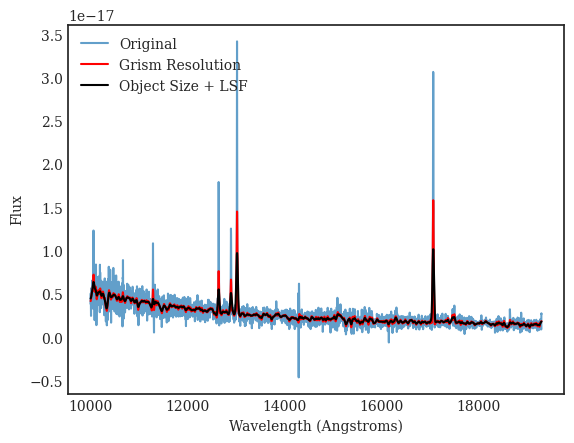

In [1273]:
plt.figure()
plt.plot(resampled_wav, resampled_flux, label = 'Original', alpha = 0.7)
plt.plot(wav, smoothed, label = 'Grism Resolution', color = 'red')
plt.plot(wav, smoothed2, label = 'Object Size + LSF', color = 'black')
plt.legend()
#plt.xlim(18200, 18550)
plt.xlabel("Wavelength (Angstroms)")
plt.ylabel("Flux")
plt.show()

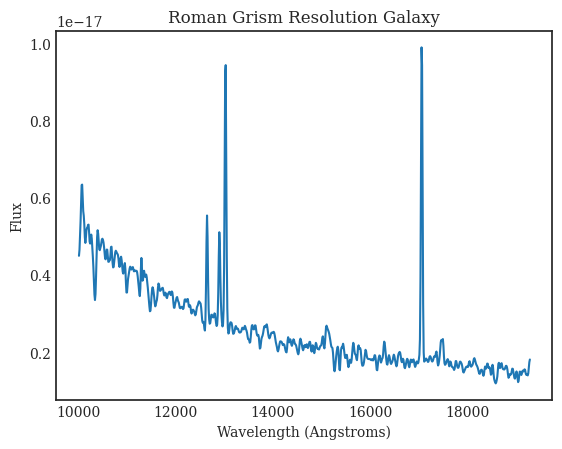

In [997]:
#plotting roman resolution
plt.figure()
plt.plot(roman_wav, roman_flux)
plt.ylabel('Flux')
plt.xlabel('Wavelength (Angstroms)')
plt.title('Roman Grism Resolution Galaxy')
plt.show()

## Comparison Between Roman and SDSS:

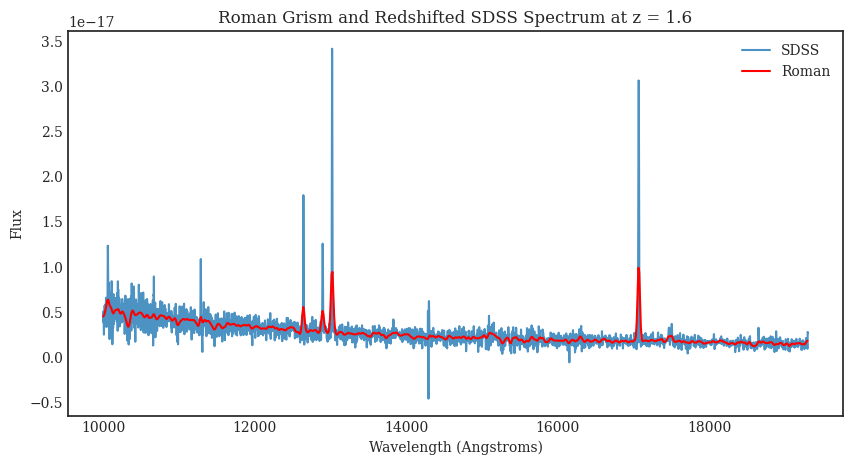

In [1003]:
plt.figure(figsize = (10, 5))
plt.plot(resampled_wav, resampled_flux, label = 'SDSS', alpha = 0.8)
plt.plot(roman_wav, roman_flux, label = 'Roman', color = 'red')
plt.title("Roman Grism and Redshifted SDSS Spectrum at z = 1.6")
plt.legend()
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel("Flux")
plt.show()

# **Part 2: Fitting H-$\alpha$ line to Roman Spectra**

This process extracts a spectum with many peak likefeatures visible. 
Those are the emission lines.


1. Galaxies:
   - Star-forming regions: Young stars ionize hydrogen gas, producing emission lines like H-alpha (6563 Å) and H-beta (4861 Å). Metal lines, like [O III] 5007 Å and [N II] 6584 Å, arise from ionized gas.

2. Active Galactic Nuclei (AGN):
   - Broad lines: High-velocity gas near the black hole produces Doppler-broadened lines like H-alpha and H-beta.
   - Narrow lines: Ionized gas in outer regions forms narrow lines like [O III] 5007 Å.
   - Highly ionized lines: X-rays create lines from elements like neon and iron.

3. Stars:
   - Hot stars: Produce hydrogen and helium emission lines.
   - Cool stars: Show molecular and metal emission lines due to lower temperatures.

## Function Definitions

In [1042]:
# Define a Gaussian function
def gaussian(wavelength, amplitude, mean, sigma, cont):
    return amplitude * np.exp(-0.5 * ((wavelength - mean) / sigma) ** 2) + cont


Notes: This function models a Gaussian curve with parameters:

amplitude: Peak height of the Gaussian.

mean: Central wavelength of the Gaussian.

sigma: Dispersion (width) of the Gaussian.

cont: Continuum

Function to Calculate Line Flux

In [1047]:
# Function to calculate line flux (integral of Gaussian)
def calculate_line_flux(amplitude, sigma):
    return amplitude * sigma * np.sqrt(2 * np.pi)

The integral of a Gaussian curve gives the line flux. 

This formula calculates the total flux under the Gaussian using the amplitude and sigma

# Fitting a curve for emission lines

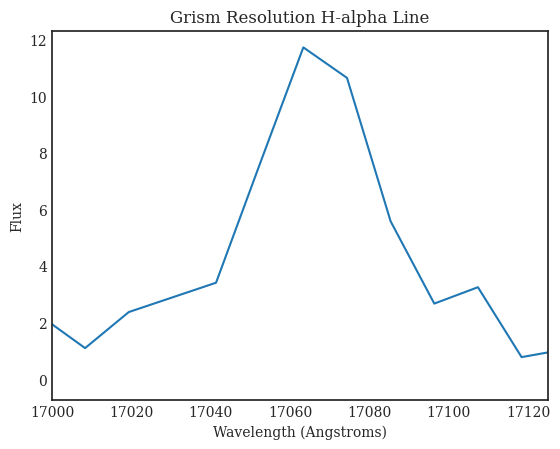

In [1381]:
data1=np.loadtxt('/Users/slkumar/Downloads/roman_emission_line_galaxy1_v3.txt')
roman_wav1 = data1.T[0]
roman_flux1 = data1.T[1] * 1e18
roman_flux_err = data1.T[2]

plt.figure()
plt.plot(roman_wav, roman_flux)
plt.ylabel('Flux')
plt.xlabel('Wavelength (Angstroms)')
plt.title('Grism Resolution H-alpha Line')
plt.xlim(17000, 17125)
#plt.ylim(1.2e-18, 3.0e-18)
plt.show()

## Step 1: Mask data to only include H-alpha

In [1305]:
# Fit the Gaussian to the data
# You might need to mask or restrict the wavelength range around the line
mask = (roman_wav > 16900) & (roman_wav < 17200)  # Adjust to your line's region

### Step 2: Use `curve_fit` 

In [1387]:
# Define an initial guess for fitting
initial_guess = [10, 17075, 15, 0]

Notes: Provide an initial guess for the Gaussian parameters:

1: Approximate amplitude.

18400: Approximate mean (central wavelength).

10: Approximate sigma (dispersion).

0.1: Approximate flux in units of 10^(-17) erg/cm^2/

In [1389]:
bounds = ([0, 16900, 1, 0], [np.inf, 17200, 100, np.inf])  # Adjust as necessary

We need to put bounds as it is a noisy spectra. 
If we don't put bounds, the fit will not converge

In [1394]:

# Perform the fit with bounds
popt, pcov = curve_fit(
    gaussian, 
    roman_wav[mask], 
    roman_flux[mask], 
    p0=initial_guess, 
    bounds=bounds, 
    sigma=roman_flux_err[mask], 
    absolute_sigma=True
)

5: Initial guess for the amplitude of the H-beta line.
    
c * Redshift: Initial guess for the velocity of the line, calculated from the redshift.
    
60: Initial guess for the velocity dispersion (line width) in km/s.
    
0.1: Initial guess for a linear continuum slope.
    
0.001: Initial guess for the linear continuum intercept.
    
maxfev=10000000 ensures the fitting algorithm performs enough iterations to converge.

The variable popt_Ha[1] contains the velocity of the H-beta emission line in kilometers per second (km/s), as determined from the fit.

In [1396]:
amplitude_fit, mean_fit, sigma_fit, cont_fit = popt

Assign the best-fit parameter values to respective variables for clarity.

In [1399]:
line_flux = calculate_line_flux(amplitude_fit, sigma_fit)

Notes: Compute the line flux using the fitted amplitude and sigma.

In [1402]:
print(f"Fit Parameters:")
print(f"  Amplitude: {amplitude_fit:.2e} erg/cm^2/s/Angstrom")
print(f"  Central wavelength: {mean_fit:.4f} Angstrom")
print(f"  Line Dispersion: {sigma_fit:.4f} Angstroms")
print(f"  Cont: {cont_fit:.2e} erg/cm^2/s/Angstrom")
print(f"Line Flux: {line_flux*1e-17:.2e} erg/cm^2/s")

Fit Parameters:
  Amplitude: 1.02e+01 erg/cm^2/s/Angstrom
  Central wavelength: 17066.6597 Angstrom
  Line Dispersion: 13.6445 Angstroms
  Cont: 1.78e+00 erg/cm^2/s/Angstrom
Line Flux: 3.50e-15 erg/cm^2/s


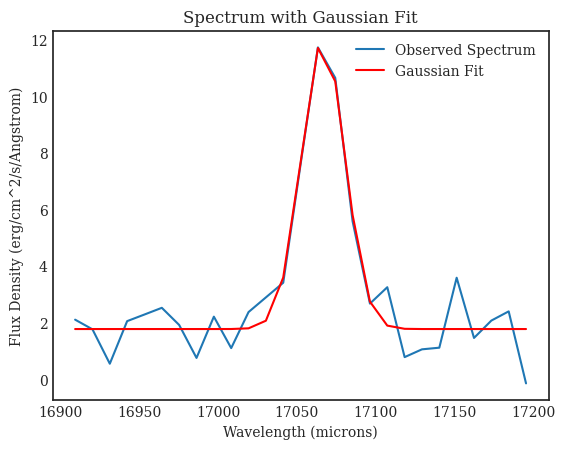

In [1404]:
# Extract fit parameters

# Print fit parameters and line flux


# Plot the fit
plt.plot(roman_wav[mask], roman_flux[mask], label="Observed Spectrum")
plt.plot(
    roman_wav[mask],
    gaussian(roman_wav[mask], *popt),
    label="Gaussian Fit",
    color="red",
)
plt.xlabel("Wavelength (microns)")
plt.ylabel("Flux Density (erg/cm^2/s/Angstrom)")
plt.title("Spectrum with Gaussian Fit")
plt.legend()
plt.show()


In [1406]:
n_iter = 100

Define the number of Monte Carlo iterations. 

This determines how many times the flux data will be perturbed and refitted

In [1409]:
amplitude_dist, mean_dist, sigma_dist, flux_dist = [], [], [], []


Create empty lists to store the results of each iteration for the fitted parameters 

(amplitude, mean, sigma) and the computed flux.

In [1412]:

for _ in range(n_iter): # Repeat the following steps n_iter times to generate a distribution of fitted parameters.
    # Perturb the flux values
    
    perturbed_flux = roman_flux[mask] + np.random.normal(0, roman_flux_err[mask], size=roman_flux[mask].shape) # 
# Add random noise to the observed flux values.np.random.normal(0, roman_flux_err[mask], size=...) generates random Gaussian noise with a mean of 0 and standard deviation equal to the flux uncertainty (roman_flux_err[mask]).This simulates how the flux values might vary due to measurement errors.
    
    # Refit the Gaussian
    popt_iter, _ = curve_fit(gaussian, roman_wav[mask], perturbed_flux, p0=initial_guess) # Perform Gaussian fitting on the perturbed flux data using curve_fit.
#  popt_iter: Optimal parameters (amplitude, mean, sigma, and baseline) for the current iteration.
    
    # Extract the parameters and calculate the flux
    amplitude_iter, mean_iter, sigma_iter, baseline_iter = popt_iter
    flux_iter = calculate_line_flux(amplitude_iter, sigma_iter)

    # Extract the best-fit parameters for this iteration.
    #Compute the line flux using the same formula as before (calculate_line_flux).
    
    # Store the parameters
    amplitude_dist.append(amplitude_iter)
    mean_dist.append(mean_iter)
    sigma_dist.append(sigma_iter)
    flux_dist.append(flux_iter)

    # Append the fitted parameters and flux value from this iteration to their respective lists

# Calculate uncertainties
amplitude_err = np.std(amplitude_dist)
mean_err = np.std(mean_dist)
sigma_err = np.std(sigma_dist)
flux_err = np.std(flux_dist)

# Use the standard deviation (np.std) of the distributions to quantify the uncertainty for each parameter.
#The variability across iterations reflects the uncertainty in the fitting process due to the flux noise

print("\nMonte Carlo Results (Uncertainties):")
print(f"Amplitude: {amplitude_fit:.3f} ± {amplitude_err:.3f}")
print(f"Central wavelength: {mean_fit:.3f} ± {mean_err:.3f}")
print(f"Line dispersion: {sigma_fit:.3f} ± {sigma_err:.3f}")
print(f"Line Flux: {line_flux*1e-17:.3e} ± {flux_err*1e-17:.3e}")

# Print the best-fit values (amplitude_fit, mean_fit, sigma_fit, line_flux) along with their uncertainties (amplitude_err, mean_err, sigma_err, flux_err).
#The uncertainties indicate the level of confidence in the fitted parameters based on the data's noise level.


Monte Carlo Results (Uncertainties):
Amplitude: 10.238 ± 0.000
Central wavelength: 17066.660 ± 0.000
Line dispersion: 13.645 ± 0.000
Line Flux: 3.502e-15 ± 1.137e-30


In [1096]:
H_alpha_rest = 6562.819 # This is the rest-frame wavelength of the Hα line in Angstroms. It is a known constant.
H_alpha_obs= popt[1] # he observed wavelength of the Hα line (H_alpha_obs) is extracted from the Gaussian fitting results (popt[1]), which corresponds to the fitted mean of the Gaussian.


In [1098]:
Redshift = (H_alpha_obs - H_alpha_rest)/H_alpha_rest
# This equation calculates how much the wavelength has shifted due to the object's motion (e.g., from the expansion of the universe)

In [1100]:
Redshift_err=mean_err/mean_fit
# The uncertainty in the redshift is proportional to the fractional uncertainty in the observed wavelength (mean_err / mean_fit).
#mean_err: Standard deviation of the mean from the Monte Carlo simulation.
#mean_fit: Fitted mean wavelength from the Gaussian

In [1102]:
print("The redshift is", np.round(Redshift,3))
print("The redshift error is", np.round(Redshift_err,3))


The redshift is 1.592
The redshift error is 0.0


# Exercise - Try it on your own! 

### Try degrading and fitting an emission line to one of the galaxy spectra located in the `spectra/galaxy` folder in the GitHub 

**Challenge**: Fit H-$\alpha$ and NII lines together using the `Ha_NII_gauss_model_single` function defined earlier

In [140]:
#load in spectra 

#put it to Roman resolution 

#fit emission line